In [7]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image, ImageEnhance
import unicodedata
import tensorflow as tf

from glob import glob
from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from keras.preprocessing.image import ImageDataGenerator

In [8]:
plt.rcParams["font.family"] = 'AppleGothic'

In [9]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt

In [10]:
base_dir = '/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/'

In [11]:
data_folder = glob(base_dir + 'train/*')

data_path = []
for folder in data_folder:
    tmp = glob(folder + '/*')
    data_path += tmp
    print(folder)

/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/녹오염
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/걸레받이수정
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/꼬임
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/석고수정
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/오타공
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/울음
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/이음부불량
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/몰딩수정
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/면불량
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/창틀,문틀수정
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/피스
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/곰팡이
/Users/david.kim/Desktop/도배하자 유형분류 경진대회/데이터셋/train/반

In [13]:
data_df = pd.DataFrame(data_path, columns=['path'])
data_df['label'] = data_df['path'].apply(lambda x: x.split('/')[-2])
data_df

,path,label
0,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,녹오염
1,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,녹오염
2,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,녹오염
3,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,녹오염
4,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,녹오염
...,...,...
3452,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,틈새과다
3453,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,틈새과다
3454,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,틈새과다
3455,/Users/david.kim/Desktop/도배하자 유형분류 ᄀ...,틈새과다


In [14]:
np.sum(data_df['label'].value_counts())

3457

In [15]:
data_df['label'] = data_df['label'].apply(lambda x: unicodedata.normalize('NFKC', x))

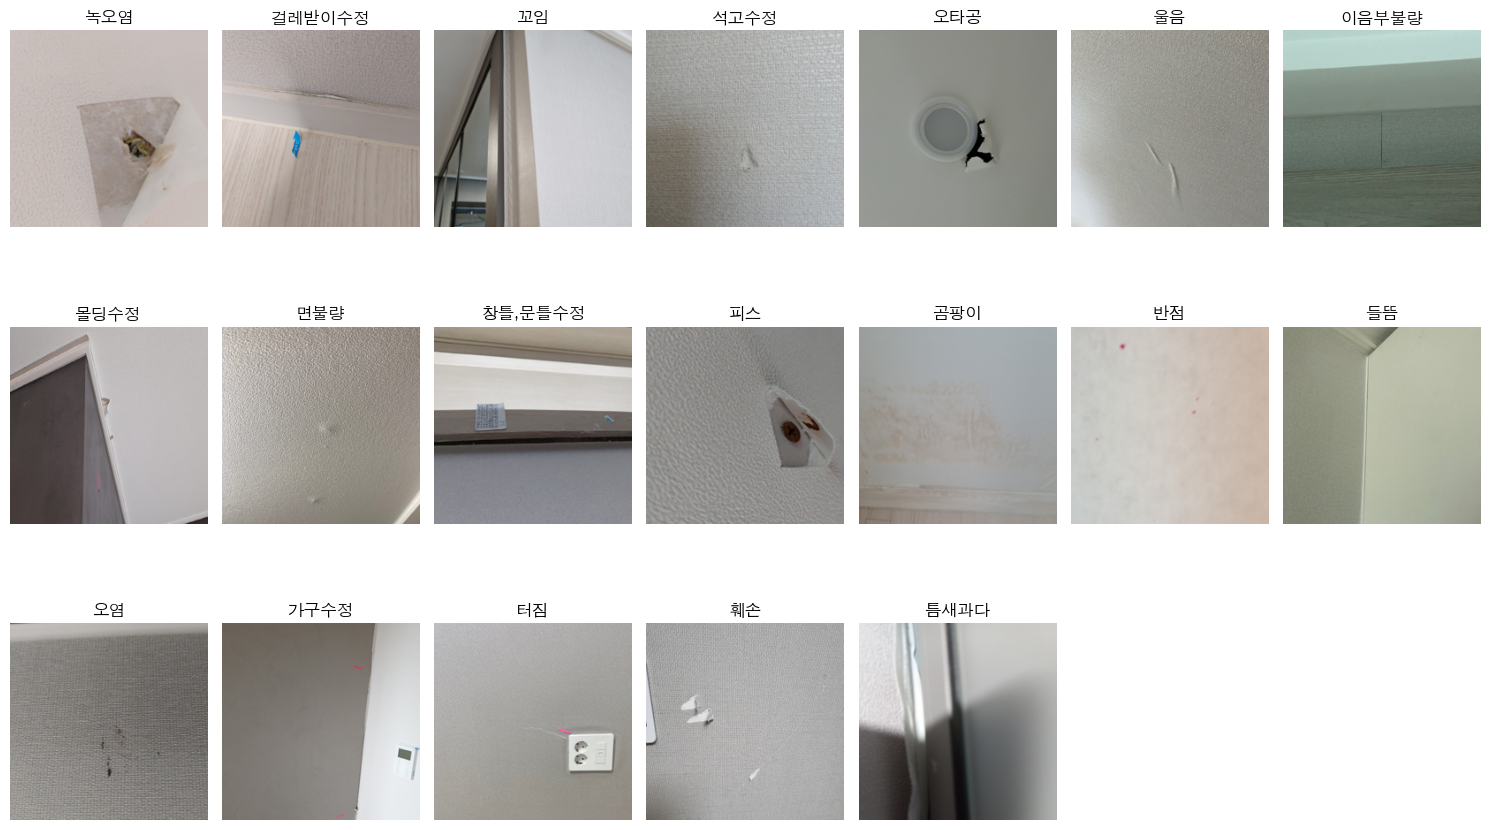

In [16]:
plt.figure(figsize = (15,12))
for idx, i in enumerate(data_df.label.unique()):
    plt.subplot(4, 7, idx+1)
    
    df = data_df[data_df['label'] == i].reset_index(drop = True)
    # image_path = df.loc[random.randint(0, len(df))-1, 'path']
    image_path = df.loc[random.randint(0, len(df)-1), 'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(unicodedata.normalize('NFC', i))
plt.tight_layout()
plt.show()

In [17]:
def plot_images(df, label):
    plt.figure(figsize = (12,12))
    species_df = df[df['label'] == label].reset_index(drop = True)
    plt.suptitle(label)
    for idx, i in enumerate(np.random.choice(species_df['path'], 32)):
        plt.subplot(8,8,idx+1)
        image_path = i
        img = Image.open(image_path)
        img = img.resize((224,224))
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [18]:
for la in data_df['label'].unique():
    plot_images(train_df ,la)

NameError: name 'train_df' is not defined

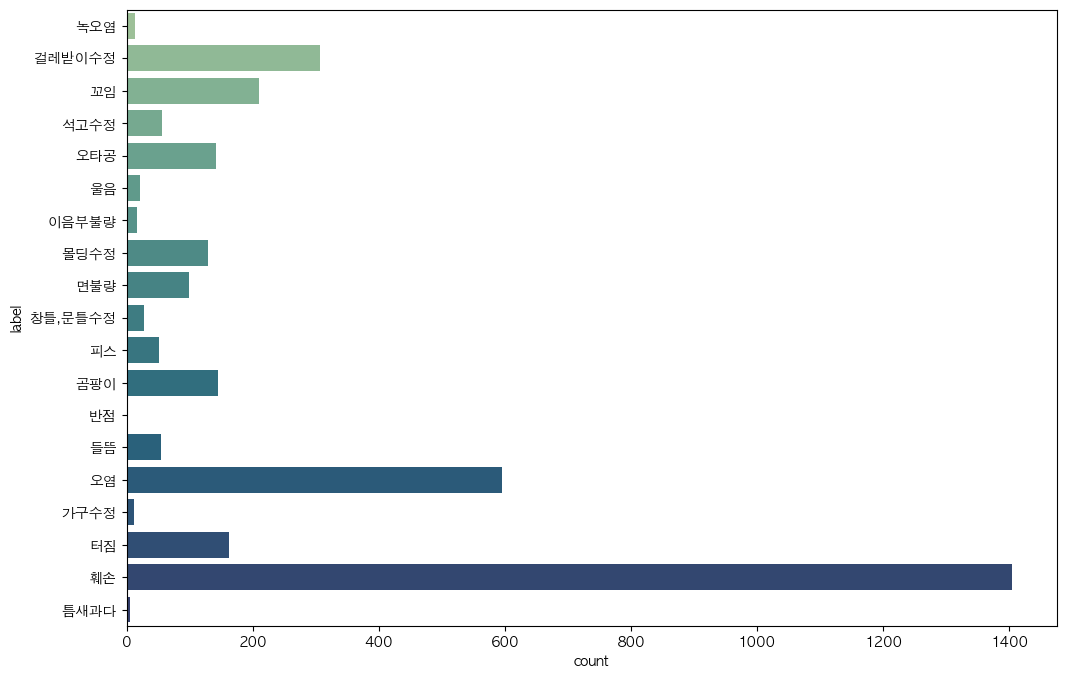

In [19]:
plt.figure(figsize=(12,8))
sns.countplot(data=data_df, y='label',  palette='crest', dodge=False)
plt.show()

## 이미지 데이터 Train, Test 분류

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

# 데이터 분리를 위한 인스턴스 생성
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

# 데이터를 분리하고 인덱스를 반환받음
train_index, test_index = next(splitter.split(data_df, data_df['label']))

# 인덱스를 사용해 데이터프레임을 분리
train_df = data_df.loc[train_index]
test_df = data_df.loc[test_index]

train_df.shape, test_df.shape

((3111, 2), (346, 2))

In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.2)

train_gen = train_datagen.flow_from_directory(base_dir+'train/',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='training')
val_gen  = train_datagen.flow_from_directory(base_dir+'train/',
                                                 target_size = (150, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',subset='validation')

Found 2772 images belonging to 19 classes.
Found 685 images belonging to 19 classes.


## 딥러닝 CNN 모델로 베이스라인 모델링

In [22]:
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[150, 150, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
cnn.add(tf.keras.layers.Dense(units=19, activation='softmax'))

# Compiling the CNN
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41472)             0         
                                                                 
 dense (Dense)               (None, 128)               5

## 모델 성능확인

In [23]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
87/87 [==============================] - 34s 388ms/step - loss: 2.1610 - accuracy: 0.3882 - val_loss: 1.9823 - val_accuracy: 0.4102
Epoch 2/10
87/87 [==============================] - 34s 386ms/step - loss: 1.9480 - accuracy: 0.4102 - val_loss: 1.8922 - val_accuracy: 0.4321
Epoch 3/10
87/87 [==============================] - 34s 391ms/step - loss: 1.7353 - accuracy: 0.4607 - val_loss: 1.9220 - val_accuracy: 0.4277
Epoch 4/10
87/87 [==============================] - 34s 386ms/step - loss: 1.5005 - accuracy: 0.5328 - val_loss: 1.8721 - val_accuracy: 0.4277
Epoch 5/10
87/87 [==============================] - 34s 388ms/step - loss: 1.1940 - accuracy: 0.6169 - val_loss: 1.9997 - val_accuracy: 0.4555
Epoch 6/10
87/87 [==============================] - 33s 382ms/step - loss: 0.9507 - accuracy: 0.6923 - val_loss: 2.3050 - val_accuracy: 0.4686
Epoch 7/10
87/87 [==============================] - 34s 385ms/step - loss: 0.7533 - accuracy: 0.7583 - val_loss: 2.3856 - val_accuracy: 0.4599

## 모델 성능 높이기

### 데이터 증강으로 이미지 로드

In [26]:
num_classes = 19
class_weights = dict(zip(range(num_classes), ((data_df['label'] == i).mean() for i in range(num_classes))))
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path', # 파일위치 열이름
        y_col='label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest",
        class_weight=class_weights # 클래스 가중치 적용
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        class_weight=class_weights # 클래스 가중치 적용
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='path',
        y_col='label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

## 전이학습을 사용해서 모델 성능 높이기

In [27]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(19, activation='softmax')(x)
    # 라벨 개수가 19개이기 때문에 Dencs도 19로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 2800 validated image filenames belonging to 19 classes.
Found 311 validated image filenames belonging to 19 classes.
Found 346 validated image filenames belonging to 17 classes.


DenseNet121          trained in 167.14 sec
MobileNetV2          trained in 42.29 sec
DenseNet201          trained in 247.58 sec
EfficientNetB0       trained in 62.82 sec
EfficientNetB1       trained in 84.61 sec
InceptionV3          trained in 133.24 sec
MobileNetV3Large     trained in 37.31 sec
ResNet152V2          trained in 504.23 sec
ResNet50             trained in 184.72 sec
ResNet50V2           trained in 161.64 sec
VGG19                trained in 746.56 sec
VGG16                trained in 589.83 sec
Xception             trained in 209.47 sec


In [28]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

11/11 [==============================] - 18s 1s/step
**DenseNet121 has a 61.85% accuracy on the test set**
11/11 [==============================] - 5s 341ms/step
**MobileNetV2 has a 62.72% accuracy on the test set**
11/11 [==============================] - 29s 3s/step
**DenseNet201 has a 63.87% accuracy on the test set**
11/11 [==============================] - 9s 670ms/step
**EfficientNetB0 has a 40.75% accuracy on the test set**
11/11 [==============================] - 11s 797ms/step
**EfficientNetB1 has a 40.75% accuracy on the test set**
11/11 [==============================] - 16s 1s/step
**InceptionV3 has a 63.58% accuracy on the test set**
11/11 [==============================] - 5s 343ms/step
**MobileNetV3Large has a 41.91% accuracy on the test set**
11/11 [==============================] - 60s 5s/step
**ResNet152V2 has a 69.65% accuracy on the test set**
11/11 [==============================] - 25s 2s/step
**ResNet50 has a 41.62% accuracy on the test set**
11/11 [=============

,model,val_accuracy,accuracy,Training time (sec)
0,ResNet50V2,0.6367,0.7023,161.64
1,ResNet152V2,0.6463,0.6965,504.23
2,DenseNet201,0.6334,0.6387,247.58
3,InceptionV3,0.5659,0.6358,133.24
4,MobileNetV2,0.6077,0.6272,42.29
5,DenseNet121,0.6109,0.6185,167.14
6,Xception,0.5627,0.5867,209.47
7,VGG16,0.5113,0.4653,589.83
8,VGG19,0.4759,0.4335,746.56
9,MobileNetV3Large,0.4469,0.4191,37.31


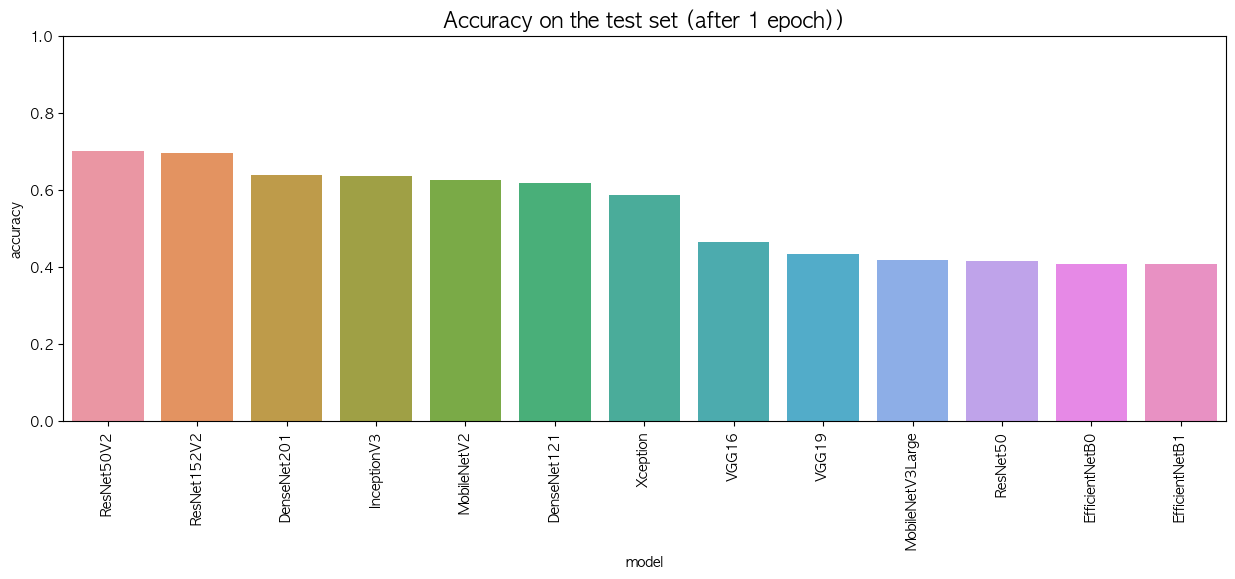

In [29]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

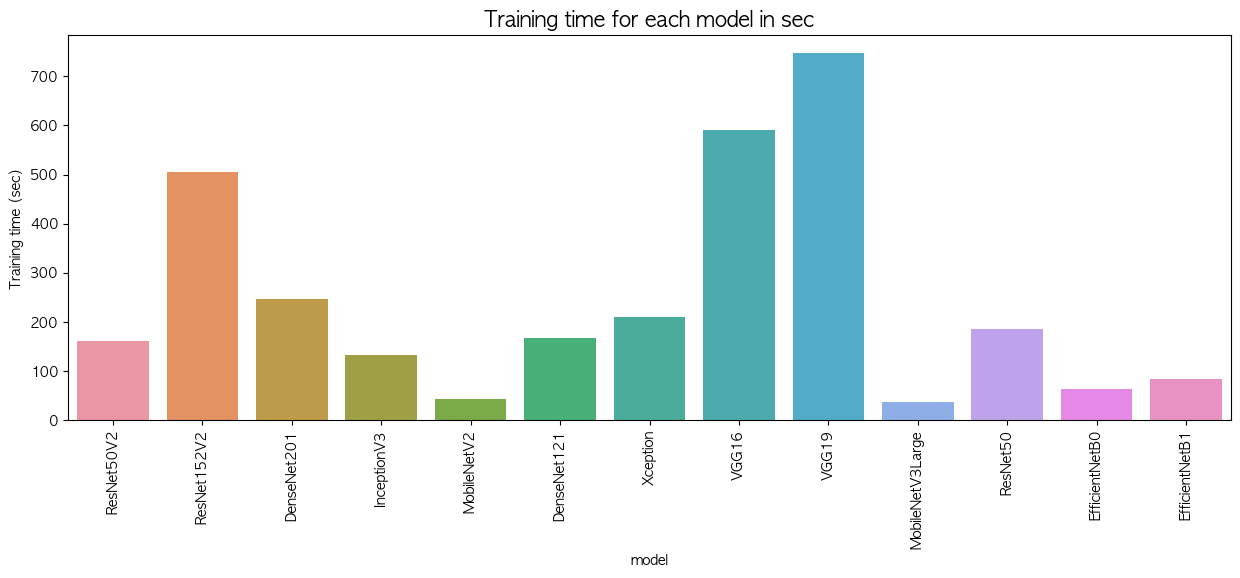

In [30]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

## 모델 성능 확인 - ResNET50V2, ResNet152V2, DenseNet201

### DenseNet201

In [32]:
train_df, test_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 2800 validated image filenames belonging to 19 classes.
Found 311 validated image filenames belonging to 19 classes.
Found 346 validated image filenames belonging to 17 classes.
Epoch 1/10
88/88 [==============================] - 260s 3s/step - loss: 1.4349 - accuracy: 0.5514 - val_loss: 1.1699 - val_accuracy: 0.6592
Epoch 2/10
88/88 [==============================] - 245s 3s/step - loss: 0.9239 - accuracy: 0.7089 - val_loss: 1.0135 - val_accuracy: 0.7138
Epoch 3/10
88/88 [==============================] - 246s 3s/step - loss: 0.7293 - accuracy: 0.7575 - val_loss: 0.9481 - val_accuracy: 0.7106
Epoch 4/10
88/88 [==============================] - 250s 3s/step - loss: 0.6151 - accuracy: 0.7889 - val_loss: 1.0344 - val_accuracy: 0.7074
Epoch 5/10
88/88 [==============================] - 251s 3s/step - loss: 0.4749 - accuracy: 0.8396 - val_loss: 0.9480 - val_accuracy: 0.7331
Epoch 6/10
88/88 [==============================] - 254s 3s/step - loss: 0.3939 - accuracy: 0.8639 - val_loss: 

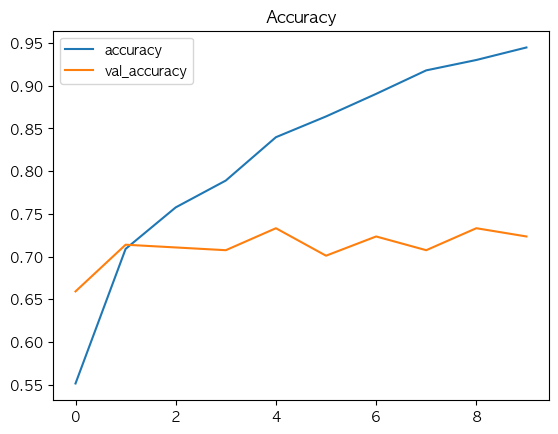

In [34]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

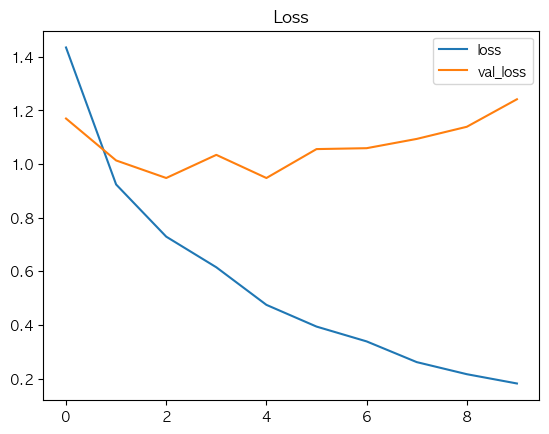

In [35]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [37]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

11/11 [==============================] - 28s 2s/step
Accuracy on the test set: 68.50%


### ResNet152V2

In [40]:
train_df,test_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet152V2)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 2800 validated image filenames belonging to 19 classes.
Found 311 validated image filenames belonging to 19 classes.
Found 346 validated image filenames belonging to 17 classes.
Epoch 1/10
88/88 [==============================] - 528s 6s/step - loss: 1.3892 - accuracy: 0.5654 - val_loss: 1.1553 - val_accuracy: 0.6431
Epoch 2/10
88/88 [==============================] - 499s 6s/step - loss: 0.8160 - accuracy: 0.7243 - val_loss: 1.0892 - val_accuracy: 0.7010
Epoch 3/10
88/88 [==============================] - 484s 6s/step - loss: 0.5601 - accuracy: 0.8075 - val_loss: 1.0633 - val_accuracy: 0.7010
Epoch 4/10
88/88 [==============================] - 488s 6s/step - loss: 0.3854 - accuracy: 0.8736 - val_loss: 1.1475 - val_accuracy: 0.7138
Epoch 5/10
88/88 [==============================] - 512s 6s/step - loss: 0.2730 - accuracy: 0.9114 - val_loss: 1.1643 - val_accuracy: 0.6945
Epoch 6/10
88/88 [==============================] - 517s 6s/step - loss: 0.1740 - accuracy: 0.9493 - val_loss: 

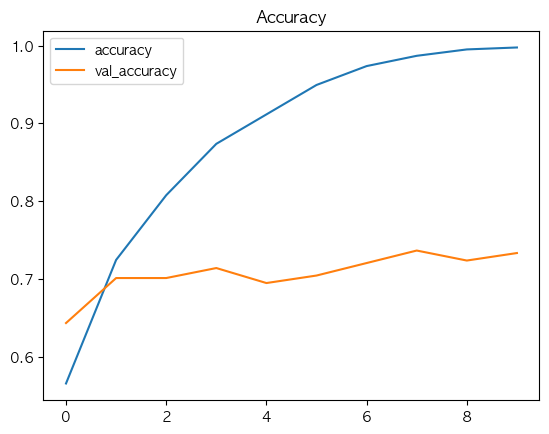

In [41]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

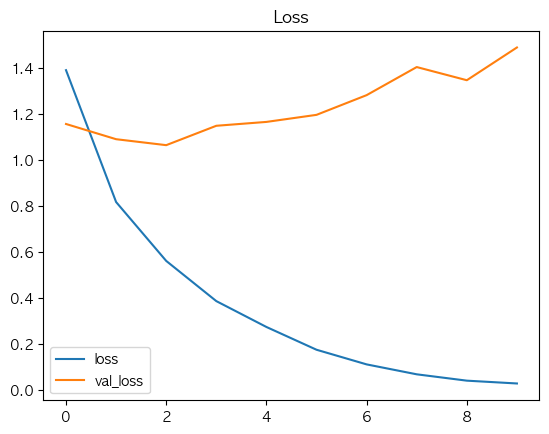

In [42]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [43]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

11/11 [==============================] - 58s 5s/step


# Accuracy on the test set: 69.94%

In [44]:
model.save("/Users/david.kim/Desktop/도배하자 유형분류 경진대회/모델/ResNet152V2")

INFO:tensorflow:Assets written to: /Users/david.kim/Desktop/도배하자 유형분류 경진대회/모델/ResNet152V2/assets


INFO:tensorflow:Assets written to: /Users/david.kim/Desktop/도배하자 유형분류 경진대회/모델/ResNet152V2/assets


### ResNet 50 V2

In [ ]:
train_df,test_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.ResNet50V2)
history = model.fit(train_images,validation_data=val_images,epochs=10)

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
    
y_test = list(test_df.label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

In [ ]:
model.save("/Users/david.kim/Desktop/도배하자 유형분류 경진대회/모델/ResNet50V2")

In [ ]:
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)